# IMAGE CLASSIFICATION OF SKIN LESIONS USING DEEP LEARNING 

The dataset is downloaded from Kaggle.
* To do this, the kaggle API (kaggle.json) file is first downloaded and uploaded to the folder that I am working with.
* The next step is to create a folder to save the dataset and set the security preferences.
* After that, I downloaded the "ISIC 2018 Skin Legion Dataset", and unzipped it.
* The dataset contains two folders and its meta in form of a csv file and the file is about 5.20GB

In [ ]:
!pip install kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
import os
from glob import glob
import pandas as pd
from skimage.io import imread
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
print('Tf-version:', tf.__version__)


Tf-version: 2.10.0


In [2]:
# SETTING THE BASE DIRECTORY
base_dir = os.path.join('../skin-legion-deep-learning-project-/Data')

In [3]:
IMGid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

skin_lesion_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesions'
}

In [5]:
class_names = ['Actinic keratoses','Basal cell carcinoma',
               'Benign keratosis-like lesions ', 'Dermatofibroma', 
               'Melanocytic nevi','Melanoma', 'Vascular lesions']

In [4]:
dataset = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
dataset['skin_lesion_type'] = dataset['dx'].map(skin_lesion_dict.get) 
dataset['img_path'] = dataset['image_id'].map(IMGid_path_dict.get)
dataset['skin_lesion_codes'] = pd.Categorical(dataset['skin_lesion_type']).codes
dataset.sample(3)

lesion_id      image_id   dx    dx_type   age     sex localization  \
5418  HAM_0004815  ISIC_0031342   nv  follow_up  60.0    male      abdomen   
5147  HAM_0004771  ISIC_0024622   nv  follow_up  55.0    male        trunk   
874   HAM_0003881  ISIC_0029061  bkl  consensus  70.0  female         face   

                   skin_lesion_type  \
5418               Melanocytic nevi   
5147               Melanocytic nevi   
874   Benign keratosis-like lesions   

                                               img_path  skin_lesion_codes  
5418  ../skin-legion-deep-learning-project-/Data/HAM...                  4  
5147  ../skin-legion-deep-learning-project-/Data/HAM...                  4  
874   ../skin-legion-deep-learning-project-/Data/HAM...                  2

In [6]:
num_classes =  len(dataset['skin_lesion_type'].unique())
print("There are", num_classes, "clases of skin lesions.")

There are 7 clases of skin lesions.


In [7]:
dataset[['skin_lesion_codes', 'skin_lesion_type']].sort_values('skin_lesion_codes').drop_duplicates()

skin_lesion_codes               skin_lesion_type
9804                  0              Actinic keratoses
2528                  1           Basal cell carcinoma
1018                  2  Benign keratosis-like lesions
1159                  3                 Dermatofibroma
7050                  4               Melanocytic nevi
1622                  5                       Melanoma
2413                  6               Vascular lesions

Upload all the image uisng the line of code below

In [6]:
dataset['image'] = dataset['img_path'].map(imread)

View five images each for every class

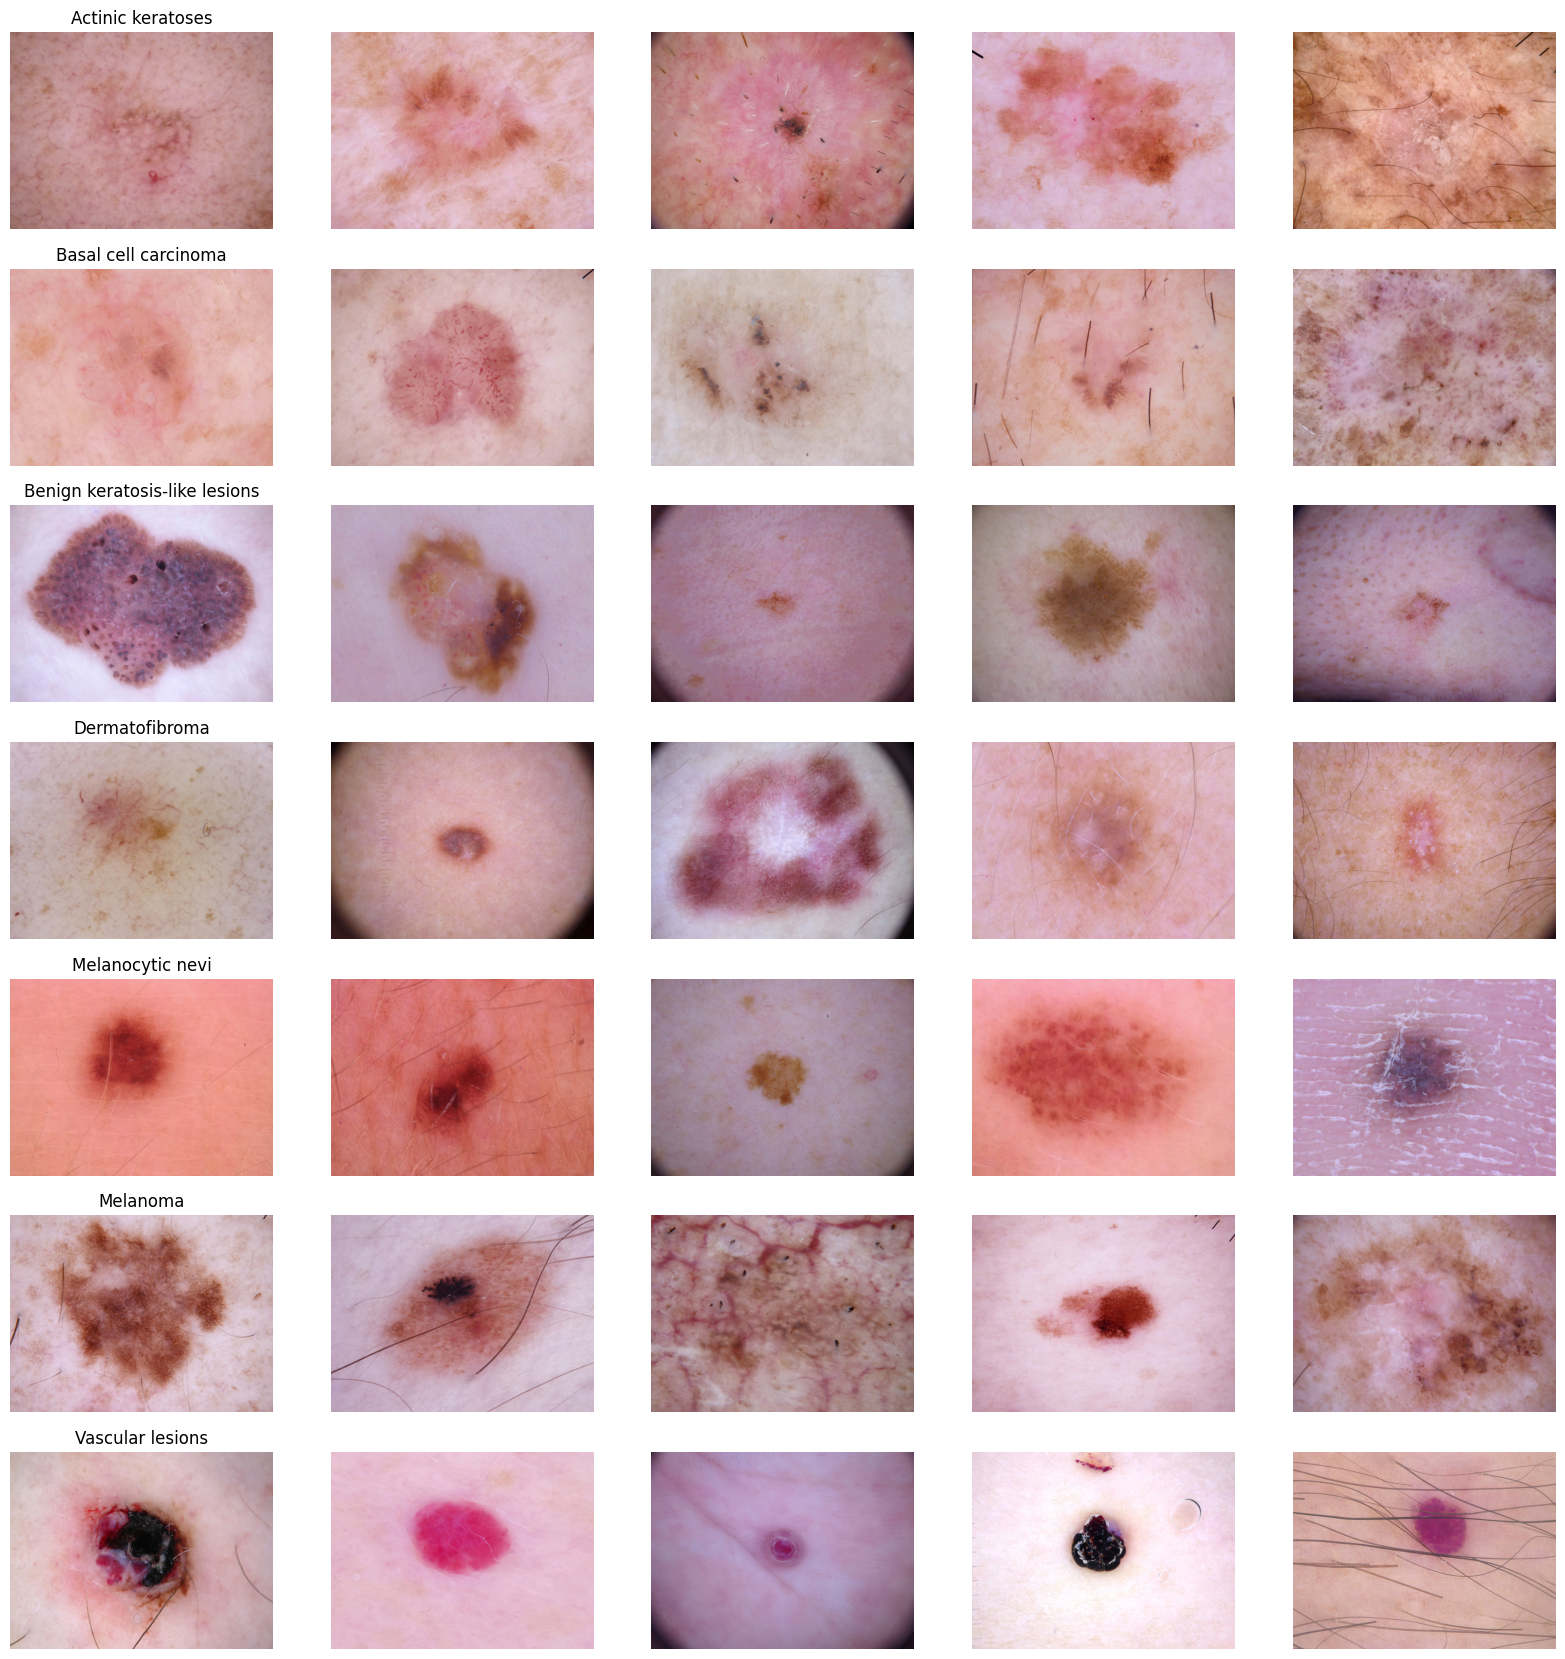

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         dataset.sort_values(['skin_lesion_type']).groupby('skin_lesion_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# UNIVARIATE ANALYSIS

<AxesSubplot: title={'center': 'Skin Lesion Type'}>

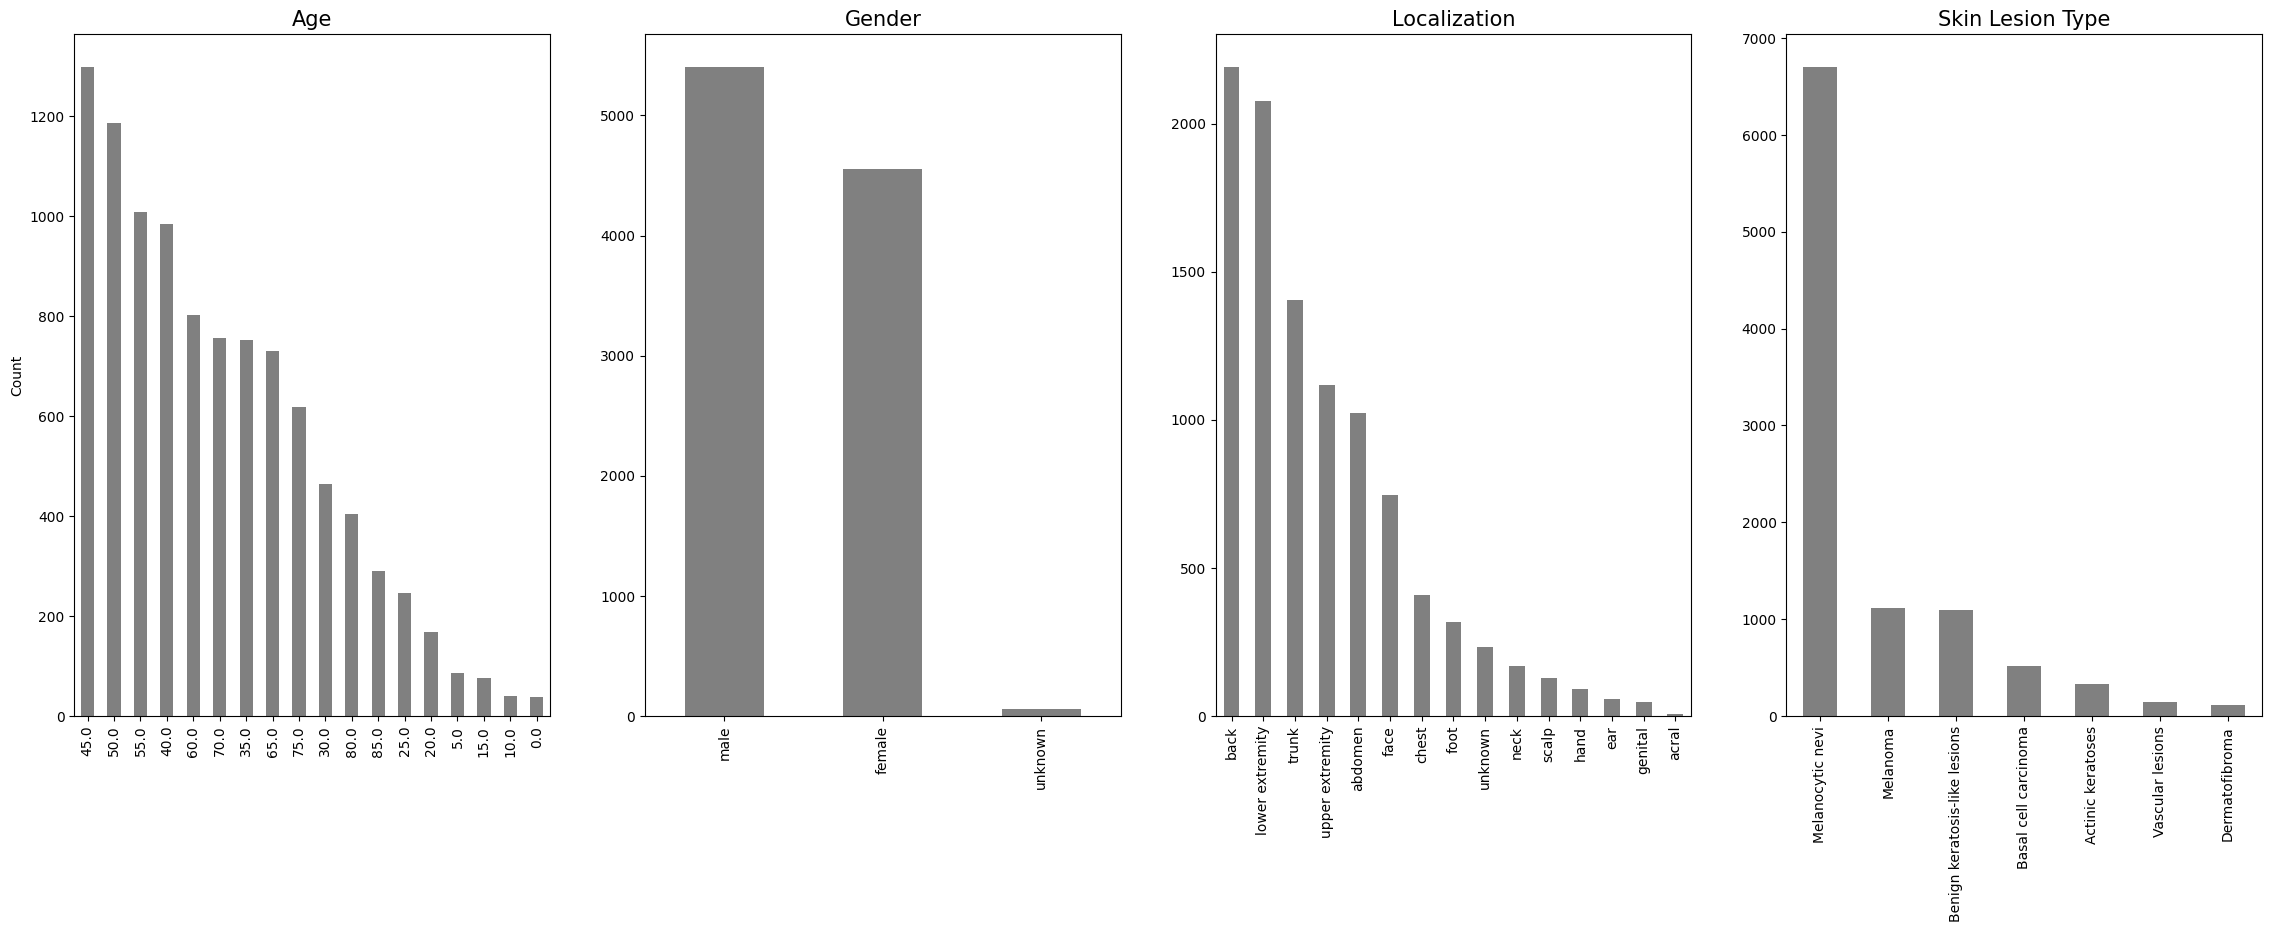

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,15))
plt.subplots_adjust(left=0.125, bottom=1, right=1.0, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("Age",fontsize=15)
plt.ylabel("Count")
dataset['age'].value_counts().plot.bar(color ='gray')

plt.subplot(2,4,2)
plt.title("Gender",fontsize=15)
dataset['sex'].value_counts().plot.bar(color ='gray')

plt.subplot(2,4,3)
plt.title("Localization",fontsize=15)
plt.xticks(rotation=45)
dataset['localization'].value_counts().plot.bar(color ='gray')

plt.subplot(2,4,4)
plt.title("Skin Lesion Type",fontsize=15)
dataset['skin_lesion_type'].value_counts().plot.bar(color ='gray')

# DATA PREPROCESSING

Missing values

In [7]:
dataset.isnull().sum()

lesion_id             0
image_id              0
dx                    0
dx_type               0
age                  57
sex                   0
localization          0
skin_lesion_type      0
img_path              0
skin_lesion_codes     0
image                 0
dtype: int64

In [7]:
# Fill in the missing value with the mean and check again 
dataset['age'].fillna(int(dataset['age'].mean()),inplace=True)
dataset.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
skin_lesion_type     0
img_path             0
skin_lesion_codes    0
image                0
dtype: int64

View the number of images and the size of each image

In [15]:
dataset['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [8]:
dataset['image'] = dataset['img_path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [17]:
# Skin Lesion Type Distribution
dataset['skin_lesion_type'].value_counts()

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: skin_lesion_type, dtype: int64

In [9]:
# DATA PREPARATION
trial_data = dataset.sample(3000)
features = trial_data.drop(['skin_lesion_codes'], axis = 1)
label = trial_data['skin_lesion_codes']
features = np.asarray(features['image'].tolist())
label = label.to_numpy()
# Normalizing the data
features = features/255
label = to_categorical(label,7)

In [11]:
# split the data
xtr, xte, ytr, yte = train_test_split(features, label,
                              test_size=0.2, shuffle = True, random_state = 24)
xtr, xval, ytr, yval = train_test_split(xtr, ytr,
                              test_size=0.25, shuffle = True, random_state = 24)

In [20]:
print(xtr.shape)
print(ytr.shape)
print(xte.shape)
print(yte.shape)
print(xval.shape)
print(yval.shape)

(1800, 224, 224, 3)
(1800, 7)
(600, 224, 224, 3)
(600, 7)
(600, 224, 224, 3)
(600, 7)


# MODEL DEVELOPMENT

In [12]:
# Import relevant models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [13]:
#Data Augmentation to solve class imbalance
data_augment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

In [14]:
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation")

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-10 10:46:21.393914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 10:46:21.396170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,x_test,y_test):
    y_pred = model.predict(x_test, verbose=1) 
    y_pred = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    cm = confusion_matrix(y_true=y_true, y_pred = y_pred)
    plt.figure(figsize=(6,6))
    plot = sns.heatmap(cm,annot=True, fmt ='0.3f',linewidth = 0.5,
            square = True, cbar = False)
    plot.set_xticklabels(class_names, rotation = 90)
    plot.set_yticklabels(class_names, rotation = 0)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted values')
    plt.show

In [16]:
from sklearn.metrics import classification_report
def make_classification_report(model, test_data,test_label):
    predictions = model.predict(test_data, verbose =1)
    predictions = predictions.argmax(axis=1)
    check=[]
    for i in range(len(test_label)):
        for j in range(7):
            if(test_label[i][j]==1):
                check.append(j)
    check=np.asarray(check)
    print(classification_report(check,predictions))

In [16]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [19]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# function for scoring roc auc score for multi-class
def get_roc_auc_score(model,x_test, y_test, average="macro"):
    y_test = y_test.argmax(axis=1)
    y_pred = model.predict(x_test, verbose=1).argmax(axis=1)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    # for (idx, c_label) in enumerate(class_names):
    #     fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    #     c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    #c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
def predict_image(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth label and image for sample n
    """
    pred_prob, true_label,image = prediction_probabilities[n], labels[n], images[n]
    
    # Get pred label
    pred_label = get_pred_label(pred_prob)
    
    # plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # change the color of the title if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else: 
        color = 'red'
    plt.title("{} {:2.0f}% ({})". format(pred_label,
                                         np.max(pred_prob)*100,
                                         true_label),
                                        color = color)

# CNN MODEL

In [34]:
tf.random.set_seed(42)
cnn_model = Sequential([
  Conv2D(16, kernel_size =(5,5), activation='relu', padding = 'same',input_shape=(224, 224, 3)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(32, kernel_size =(5,5), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(64, kernel_size =(3,3), activation='relu',padding='same',kernel_regularizer =regularizers.l2(0.001)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(128, kernel_size =(3,3), activation='relu',padding='same',kernel_regularizer =regularizers.l2(0.001)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Dropout(0.25),
  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.25),
  Dense(32, activation='relu'),
  Dense(7, activation='softmax')
])

In [36]:
tf.random.set_seed(25)
cnn_model.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8),
                metrics=["accuracy"])

data_augment.fit(xtr)


# training
cnn_history = cnn_model.fit(data_augment.flow(xtr,ytr, batch_size=32),
                              epochs = 40,
                              shuffle=True,
                              validation_data = (xval,yval),
                            #   validation_steps = len(xval) // 32,
                              verbose = 1,
                              steps_per_epoch=len(xtr) // 32
                              )

Epoch 1/40


2022-12-10 13:35:20.788445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.7274

2022-12-10 13:35:38.148800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 21s 319ms/step - loss: 0.7635 - accuracy: 0.7274 - val_loss: 0.8714 - val_accuracy: 0.6883
Epoch 2/40
56/56 [==============================] - 11s 190ms/step - loss: 0.7596 - accuracy: 0.7291 - val_loss: 0.8656 - val_accuracy: 0.6900
Epoch 3/40
56/56 [==============================] - 10s 172ms/step - loss: 0.7506 - accuracy: 0.7291 - val_loss: 0.8603 - val_accuracy: 0.6883
Epoch 4/40
56/56 [==============================] - 10s 172ms/step - loss: 0.7504 - accuracy: 0.7347 - val_loss: 0.8271 - val_accuracy: 0.7017
Epoch 5/40
56/56 [==============================] - 10s 171ms/step - loss: 0.7622 - accuracy: 0.7296 - val_loss: 0.8380 - val_accuracy: 0.7067
Epoch 6/40
56/56 [==============================] - 10s 178ms/step - loss: 0.7432 - accuracy: 0.7372 - val_loss: 0.8669 - val_accuracy: 0.6900
Epoch 7/40
56/56 [==============================] - 10s 180ms/step - loss: 0.7445 - accuracy: 0.7359 - val_loss: 0.8946 - val_accuracy: 0.6950
Epoch 8/40

In [37]:
cnn_accuracy = cnn_model.evaluate(xte,yte, verbose=0)[1]
print("CNN-model: accuracy = ",cnn_accuracy*100,"%")

CNN-model: accuracy =  70.83333730697632 %


In [ ]:
plot_loss_curves(cnn_history)

2022-12-09 22:57:08.539676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 8s 51ms/step


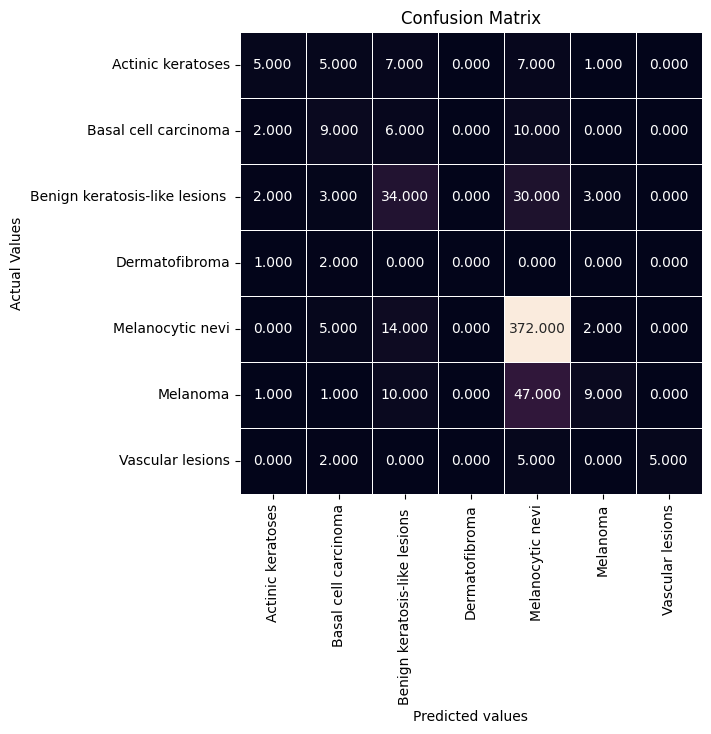

In [35]:
plot_confusion_matrix(cnn_model, xte, yte)

In [37]:
make_classification_report(cnn_model,xte,yte)

19/19 [==============================] - 2s 116ms/step
              precision    recall  f1-score   support

           0       0.45      0.20      0.28        25
           1       0.33      0.33      0.33        27
           2       0.48      0.47      0.48        72
           3       0.00      0.00      0.00         3
           4       0.79      0.95      0.86       393
           5       0.60      0.13      0.22        68
           6       1.00      0.42      0.59        12

    accuracy                           0.72       600
   macro avg       0.52      0.36      0.39       600
weighted avg       0.70      0.72      0.68       600



/Users/favechibueze/miniforge3/envs/mike_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/favechibueze/miniforge3/envs/mike_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/favechibueze/miniforge3/envs/mike_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [43]:
print('ROC AUC score for CNN model:', get_roc_auc_score(cnn_model,xte,yte))

19/19 [==============================] - 1s 78ms/step
ROC AUC score for CNN model: 63.569120222078844 %


# TRANSFER LEARNING

## MOBILE NET MODEL

In [26]:
base_model = tf.keras.applications.MobileNetV2(weights="imagenet",include_top=False,input_shape=(224,224,3))

base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))
base = data_augmentation(inputs)
base = base_model(inputs,training=False)
base = keras.layers.GlobalAveragePooling2D()(base)
base = keras.layers.Dropout(0.25)(base)
output = keras.layers.Dense(7,activation="softmax", name="output_layer")(base)
mobile_model = keras.Model(inputs=inputs, outputs=output, name="MobileNet")

mobile_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8),
                     metrics=['accuracy'])
data_augment.fit(xtr)

mobile_model_history = mobile_model.fit(data_augment.flow(xtr,ytr, batch_size=32),
                              epochs = 50,
                              shuffle=True,
                              validation_data = (xval,yval),
                              verbose = 1,
                              steps_per_epoch=len(xtr) // 32
                              )

Epoch 1/50


2022-12-10 12:14:35.622308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.2962 - accuracy: 0.6165

2022-12-10 12:14:59.914761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 38s 616ms/step - loss: 1.2962 - accuracy: 0.6165 - val_loss: 1.0408 - val_accuracy: 0.6617
Epoch 2/50
56/56 [==============================] - 18s 298ms/step - loss: 0.9728 - accuracy: 0.6804 - val_loss: 0.9765 - val_accuracy: 0.6750
Epoch 3/50
56/56 [==============================] - 15s 253ms/step - loss: 0.8778 - accuracy: 0.6987 - val_loss: 0.9121 - val_accuracy: 0.6800
Epoch 4/50
56/56 [==============================] - 14s 248ms/step - loss: 0.8170 - accuracy: 0.7183 - val_loss: 0.8783 - val_accuracy: 0.6917
Epoch 5/50
56/56 [==============================] - 13s 230ms/step - loss: 0.7819 - accuracy: 0.7376 - val_loss: 0.8674 - val_accuracy: 0.6983
Epoch 6/50
56/56 [==============================] - 14s 249ms/step - loss: 0.7772 - accuracy: 0.7302 - val_loss: 0.8228 - val_accuracy: 0.7083
Epoch 7/50
56/56 [==============================] - 14s 245ms/step - loss: 0.7311 - accuracy: 0.7449 - val_loss: 0.8493 - val_accuracy: 0.7033
Epoch 8/50

In [38]:
mn_accuracy = mobile_model.evaluate(xte,yte, verbose=0)[1]
print("MobileNet-model: accuracy = ",mn_accuracy*100,"%")

2022-12-10 14:24:07.313842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


MobileNet-model: accuracy =  72.1666693687439 %


In [ ]:
plot_loss_curves(mobile_model_history)

2022-12-10 01:03:29.048494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 8s 330ms/step


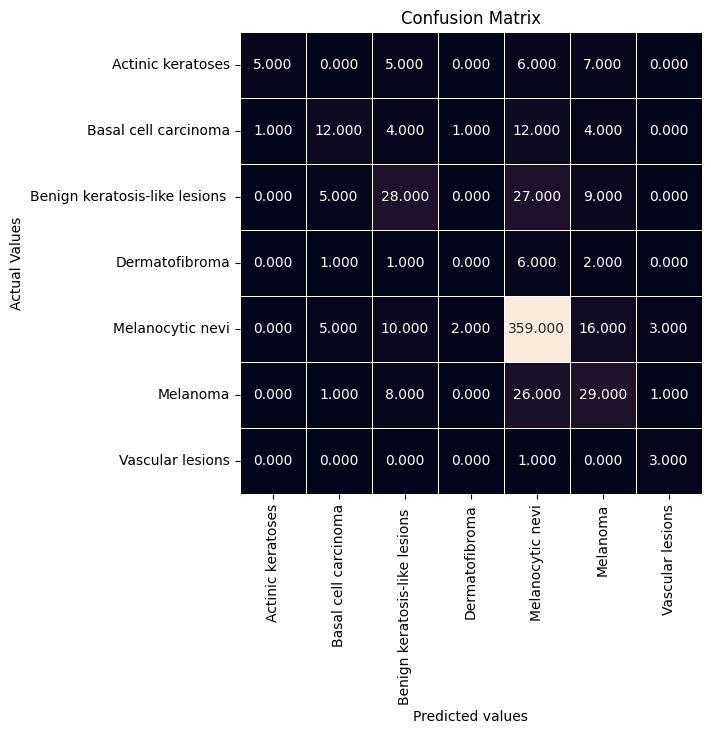

In [19]:
plot_confusion_matrix(mobile_model, xte, yte)

In [20]:
make_classification_report(mobile_model,xte,yte)

19/19 [==============================] - 5s 273ms/step
              precision    recall  f1-score   support

           0       0.83      0.22      0.34        23
           1       0.50      0.35      0.41        34
           2       0.50      0.41      0.45        69
           3       0.00      0.00      0.00        10
           4       0.82      0.91      0.86       395
           5       0.43      0.45      0.44        65
           6       0.43      0.75      0.55         4

    accuracy                           0.73       600
   macro avg       0.50      0.44      0.44       600
weighted avg       0.71      0.73      0.71       600



In [23]:
print('ROC AUC score for MobileNetV2 model:', get_roc_auc_score(mobile_model,xte,yte))

19/19 [==============================] - 4s 189ms/step
ROC AUC score for MobileNetV2 model: 0.6815833555725863


## INCEPTION NET MODEL

In [40]:
base_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",include_top=False,input_shape=(224,224,3))

base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))
base = data_augmentation(inputs)
base = base_model(inputs,training=False)
base = keras.layers.GlobalAveragePooling2D()(base)
base = keras.layers.Dropout(0.25)(base)
output = keras.layers.Dense(7,activation="softmax", name="output_layer")(base)
inception_model = keras.Model(inputs=inputs, outputs=output, name="MobileNet")

inception_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8),
                     metrics=['accuracy'])
data_augment.fit(xtr)

inception_model_history = inception_model.fit(data_augment.flow(xtr,ytr, batch_size=32),
                              epochs = 50,
                              shuffle=True,
                              validation_data = (xval,yval),
                              verbose = 1,
                              steps_per_epoch=len(xtr) // 32
                              )

Epoch 1/50


2022-12-10 14:25:07.124649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.6397

2022-12-10 14:25:48.117735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 65s 968ms/step - loss: 1.2873 - accuracy: 0.6397 - val_loss: 1.0541 - val_accuracy: 0.6667
Epoch 2/50
56/56 [==============================] - 40s 697ms/step - loss: 0.9788 - accuracy: 0.6833 - val_loss: 0.9626 - val_accuracy: 0.6700
Epoch 3/50
56/56 [==============================] - 38s 671ms/step - loss: 0.8842 - accuracy: 0.7053 - val_loss: 0.9518 - val_accuracy: 0.6667
Epoch 4/50
56/56 [==============================] - 38s 670ms/step - loss: 0.8692 - accuracy: 0.6974 - val_loss: 0.8450 - val_accuracy: 0.6917
Epoch 5/50
56/56 [==============================] - 38s 672ms/step - loss: 0.8110 - accuracy: 0.7172 - val_loss: 0.8876 - val_accuracy: 0.6917
Epoch 6/50
56/56 [==============================] - 38s 672ms/step - loss: 0.7911 - accuracy: 0.7178 - val_loss: 0.8278 - val_accuracy: 0.7000
Epoch 7/50
56/56 [==============================] - 38s 672ms/step - loss: 0.7741 - accuracy: 0.7257 - val_loss: 0.8292 - val_accuracy: 0.6917
Epoch 8/50

In [41]:
in_accuracy = inception_model.evaluate(xte,yte, verbose=0)[1]
print("InceptionNet-model: accuracy = ",in_accuracy*100,"%")

InceptionNet-model: accuracy =  72.66666889190674 %


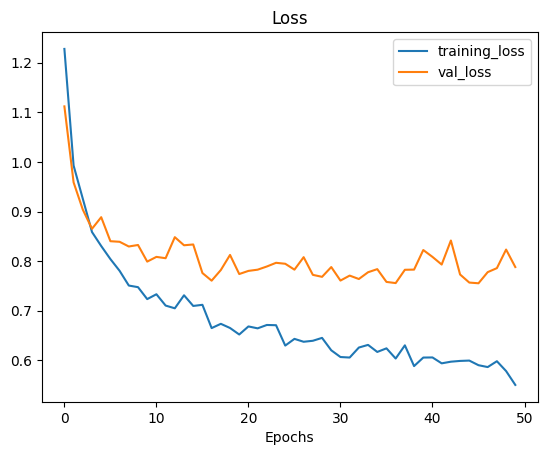

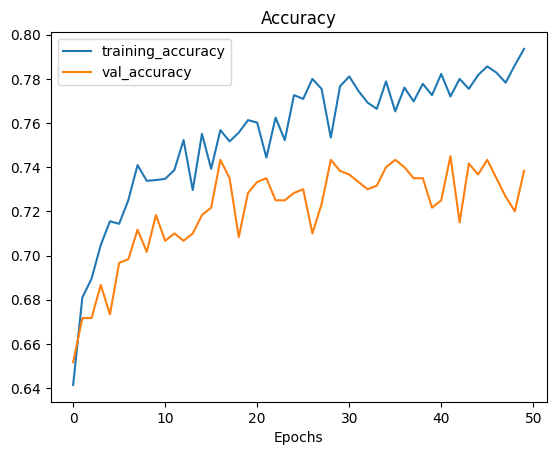

In [20]:
plot_loss_curves(inception_model_history)

2022-12-10 05:03:12.718065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 43s 1s/step


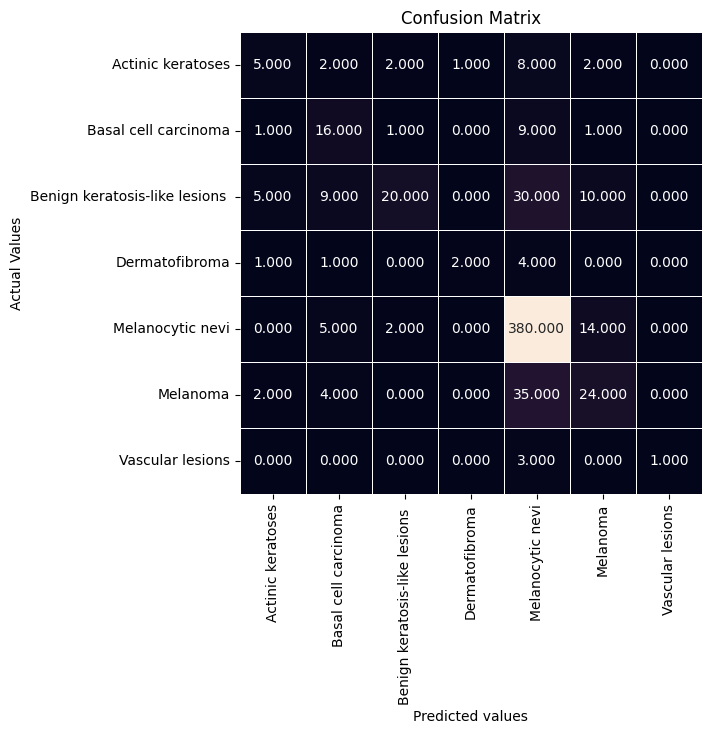

In [21]:
plot_confusion_matrix(inception_model, xte, yte)

In [22]:
make_classification_report(inception_model,xte,yte)

19/19 [==============================] - 18s 841ms/step
              precision    recall  f1-score   support

           0       0.36      0.25      0.29        20
           1       0.43      0.57      0.49        28
           2       0.80      0.27      0.40        74
           3       0.67      0.25      0.36         8
           4       0.81      0.95      0.87       401
           5       0.47      0.37      0.41        65
           6       1.00      0.25      0.40         4

    accuracy                           0.75       600
   macro avg       0.65      0.42      0.46       600
weighted avg       0.74      0.75      0.72       600



In [21]:
print('ROC AUC score for InceptionResNetV2 model:', get_roc_auc_score(inception_model,xte,yte))

NameError: name 'inception_model' is not defined

## XCEPTION MODEL

In [20]:
base_model = tf.keras.applications.Xception(weights="imagenet",include_top=False,input_shape=(224,224,3))

base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))
base = data_augmentation(inputs)
base = base_model(inputs,training=False)
base = keras.layers.GlobalAveragePooling2D()(base)
base = keras.layers.Dropout(0.25)(base)
output = keras.layers.Dense(7,activation="softmax", name="output_layer")(base)
xception_model = keras.Model(inputs=inputs, outputs=output, name="EfficienteNet")

xception_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8),
                     metrics=['accuracy'])
data_augment.fit(xtr)

xception_model_history = xception_model.fit(data_augment.flow(xtr,ytr, batch_size=32),
                              epochs = 50,
                              shuffle=True,
                              validation_data = (xval,yval),
                              verbose = 1,
                              steps_per_epoch=len(xtr) // 32
                              )

Epoch 1/50


2022-12-10 10:47:17.505917: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 10:47:18.884859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.1528 - accuracy: 0.6612

2022-12-10 10:47:48.864198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 41s 686ms/step - loss: 1.1528 - accuracy: 0.6612 - val_loss: 1.0751 - val_accuracy: 0.6617
Epoch 2/50
56/56 [==============================] - 36s 636ms/step - loss: 0.9436 - accuracy: 0.6963 - val_loss: 1.0575 - val_accuracy: 0.6617
Epoch 3/50
56/56 [==============================] - 36s 634ms/step - loss: 0.8745 - accuracy: 0.7087 - val_loss: 1.0064 - val_accuracy: 0.6650
Epoch 4/50
56/56 [==============================] - 36s 635ms/step - loss: 0.8219 - accuracy: 0.7093 - val_loss: 0.9353 - val_accuracy: 0.6683
Epoch 5/50
56/56 [==============================] - 35s 628ms/step - loss: 0.7843 - accuracy: 0.7285 - val_loss: 0.9499 - val_accuracy: 0.6683
Epoch 6/50
56/56 [==============================] - 35s 629ms/step - loss: 0.7642 - accuracy: 0.7234 - val_loss: 0.9470 - val_accuracy: 0.6733
Epoch 7/50
56/56 [==============================] - 36s 634ms/step - loss: 0.7369 - accuracy: 0.7432 - val_loss: 0.9270 - val_accuracy: 0.6717
Epoch 8/50

In [18]:
x_accuracy = xception_model.evaluate(xte,yte, verbose=0)[1]
print("Xception-model: accuracy = ",x_accuracy*100,"%")

Xception-model: accuracy =  73.00000190734863 %


In [19]:
plot_loss_curves(xception_model_history)

NameError: name 'plot_loss_curves' is not defined

2022-12-10 09:18:02.660450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 10s 488ms/step


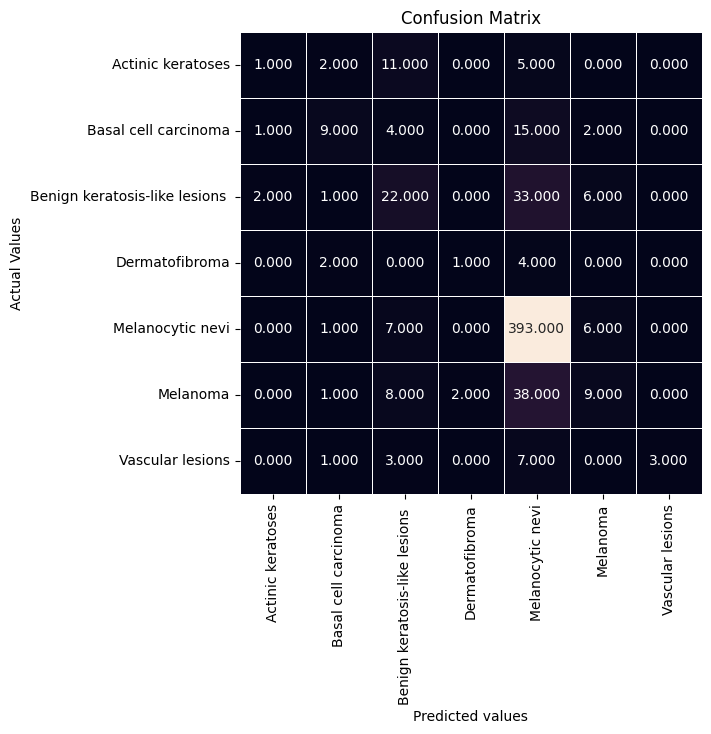

In [20]:
plot_confusion_matrix(xception_model, xte, yte)

In [21]:
make_classification_report(xception_model,xte,yte)

19/19 [==============================] - 9s 480ms/step
              precision    recall  f1-score   support

           0       0.25      0.05      0.09        19
           1       0.53      0.29      0.38        31
           2       0.40      0.34      0.37        64
           3       0.33      0.14      0.20         7
           4       0.79      0.97      0.87       407
           5       0.39      0.16      0.22        58
           6       1.00      0.21      0.35        14

    accuracy                           0.73       600
   macro avg       0.53      0.31      0.35       600
weighted avg       0.68      0.73      0.68       600



In [22]:
print('ROC AUC score for Xception model:', get_roc_auc_score(xception_model,xte,yte))

2022-12-10 11:24:56.985836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 12s 514ms/step
ROC AUC score for XceptionResNetV2 model: 0.6024651234415693
